## COV-project

In [1]:
#import modules
import os 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
#load data (contact distances, defined as the closest distance between heavy atoms of residues)
cov1_run1 = np.load("../SARS-CoV/CoV-run1-ext.heavy.15.npy")[:10000,:]
cov1_run2 = np.load("../SARS-CoV/CoV-run2-ext.heavy.15.npy")[:10000,:]
cov2_run1 = np.load("../SARS-CoV-2/CoV2-run1-ext.heavy.15.npy")
cov2_run2 = np.load("../SARS-CoV-2/CoV2-run2-ext.heavy.15.npy")
df=pd.DataFrame(np.concatenate((cov1_run1,cov1_run2,cov2_run1,cov2_run2),axis=0))

print(df)

           0         1         2         3         4         5         6     \
0      1.916014  2.011085  1.694515  2.029287  1.594777  1.450265  1.266049   
1      2.148690  2.293490  1.964657  2.334203  1.720688  1.563979  1.345276   
2      2.197925  2.330296  1.983976  2.280837  1.680037  1.571293  1.378474   
3      2.127622  2.339072  1.970491  2.356472  1.777832  1.574960  1.392945   
4      1.977998  2.011055  1.729932  2.145120  1.548704  1.445091  1.285323   
...         ...       ...       ...       ...       ...       ...       ...   
39995  1.931402  1.969122  1.421024  1.753847  1.409535  1.515369  1.205100   
39996  1.928160  1.844556  1.418152  1.763895  1.404327  1.540969  1.247907   
39997  1.959555  1.910484  1.411315  1.802429  1.469004  1.552288  1.232493   
39998  1.875769  1.930083  1.433124  1.736037  1.449374  1.554210  1.196262   
39999  1.720058  1.754015  1.337003  1.574851  1.252675  1.456237  1.195539   

           7         8         9     ...      4876 

In [ ]:
#inverse distance
df=1./df

#add label
df['cov'] = 'cov'
df.iloc[:20000,-1] = 1
df.iloc[20000:,-1] = 2

#scaled/normalized by each feature
df_scaled = df.copy()
X = df_scaled.iloc[:,:-1]
X = (X-X.mean())/X.std()
df_scaled.update(X)
df_scaled

#features
features_pre = df_scaled.iloc[:,:-1]

print('# of features before drop:', features_pre.shape[1])

#create correlation matrix
corr_matrix_before = features_pre.corr().abs()

#set a cutoff threshold (usually 0.9 or 0.85)
cut_th = 0.9

# of features before drop: 4886


In [ ]:
#change the version to avoid overwrite
output_dir = './MLP_3_github/' 

if not os.path.isdir(output_dir):
    print('Creating image folder {}. Figures will be saved here'.format(output_dir))
    os.mkdir(output_dir)

# Machine learning

In [3]:
#import scikit learn packages
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

#consider reducing dimensions when hyperparameter tuning if computationally too expensive

#RF------------------------------
############################################
RF_param_grid = {"n_estimators" : [160, 320, 640, 1280],
                 "max_depth" : [None, 5, 10, 20, 40, 160, 320],
                 "min_samples_leaf" : [1, 2, 4, 8, 16, 32, 64],
                 "max_features":['auto', 5,10,20,30]
                } 

RF_tuned_params = {'max_depth': 60,
                   'max_features': 50,
                   'min_samples_leaf': 1,
                   'n_estimators': 500,
                   'n_jobs': -1,
                   'random_state': 42
                  }

RF = RandomForestClassifier(random_state=42,n_jobs=-1).set_params(**RF_tuned_params)
#RF------------------------------
############################################

#LR------------------------------
############################################
LR_param_grid = {'penalty': ['l1', 'l2'], #note l1 only compatible with liblinear
                 'C':[0.001,0.01,1,5,10],
                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

LR_tuned_params = {'C': 1, 
                   'penalty': 'l1',
                   'solver': 'liblinear'
                  }

#LR_tuned_params = {'C': 0.001, 
#                   'penalty': 'l2', 
#                   'solver': 'newton-cg'
#                  }

LR = LogisticRegression(random_state = 42).set_params(**LR_tuned_params)

#LR------------------------------
############################################

In [11]:
#components (residues) of each contact distance pair in the same order 
cov1_pairs = np.loadtxt("../rest2/cov1pairs_resids.15.txt", dtype=int)
cov2_pairs = np.loadtxt("../rest2/cov2pairs_resids.15.txt", dtype=int)

print(cov1_pairs)
print(cov1_pairs.shape)

[[ 21 402]
 [ 21 403]
 [ 21 404]
 ...
 [615 383]
 [615 501]
 [615 502]]
(4886, 2)


In [7]:
def sum_elements(i_array):
    
    #calculate residue importance. It was derived by summing the importance of distance pairs 
    #containing a given residue and normalizing the results to have a maximum of 1.

    resid = []
    for i in i_array:
        if i[0] not in resid:
            resid.append(i[0])
    import_sum = []
    for i in resid:
        su = 0
        for j in i_array:
            if j[0] == i:
                su = su + j[1]
        import_sum.append([i,su])   
    import_sum = np.array(import_sum)
    xmax, ymax = import_sum.max(axis=0)
    import_sum[:,1] /= ymax
    import_sum = import_sum[import_sum[:,0].argsort()]
    return import_sum

#def ave_elements(i_array):
    
    #calculate residue importance. It was derived by averaging the importance of distance pairs containing a given residue 
    #and normalizing the results to have a maximum of 1.
    
#    resid = []
#    for i in i_array:
#        if i[0] not in resid:
#            resid.append(i[0])
#    import_ave = []
#    for i in resid:
#        su = 0
#        n = 0
#        for j in i_array:
#            if j[0] == i:
#                n = n +1
#                su = su + j[1]
#        import_ave.append([i,su/n])
#    import_ave = np.array(import_ave)
#    xmax, ymax = import_ave.max(axis=0)
#    import_ave[:,1] /= ymax
#    #sort
#    import_ave = import_ave[import_ave[:,0].argsort()]
#    return import_ave

In [8]:
#creat dfs to store per-residue importance
LR_impo_res_cov2=pd.DataFrame(columns = range(336,519))
RF_impo_res_cov2=pd.DataFrame(columns = range(336,519))
LR_impo_res_cov1=pd.DataFrame(columns = range(323,503))
RF_impo_res_cov1=pd.DataFrame(columns = range(323,503))
LR_impo_res_ace=pd.DataFrame(columns = range(21,616))
RF_impo_res_ace=pd.DataFrame(columns = range(21,616))
mlp_impo_res_cov2=pd.DataFrame(columns = range(336,519))
mlp_impo_res_cov1=pd.DataFrame(columns = range(323,503))
mlp_impo_res_ace=pd.DataFrame(columns = range(21,616))

In [9]:
#MLP classifier parameters, hyperparameters were tuned for an accuracy of 1
MLP = MLPClassifier(hidden_layer_sizes = (55), activation = 'relu', solver = 'adam', max_iter= 1000)

In [16]:
#Highly correlated features were
#removed with a threshold of 0.9. Specifically, we calculated the correlation matrix of input
#features, keeping the upper (right) triangular matrix without the main diagonal (to avoid
#duplication and correlation with themselves). We removed a column (i.e., feature), if any
#element(s) in the column of the upper triangular matrix is/are larger than the threshold
#value. While the order of columns (features) in the matrix is not relevant for the ML, it does
#affect which features are removed during this process, which can produce different profiles.
#Different choices of removal led to different datasets and importance profiles. Converged
#results were derived by averaging the importance profiles of different datasets generated
#by shuffling the choices 20 times.

## MLP section

#run 20 times
for run in range(0,20):
    #shuffle corr_matrix
    arr = np.arange(len(df_scaled.columns)-1)
    np.random.shuffle(arr)
    corr_matrix = corr_matrix_before.iloc[arr,arr]

    #keeping the upper (right) triangular matrix without the main diagonal
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    #removed a column (i.e., feature), if any element(s) in the column of the upper triangular matrix is/are 
    #larger than the threshold value
    to_drop = [column for column in upper.columns if any(upper[column] > cut_th)]
    df_dropped = df_scaled.drop(columns = to_drop)
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']
    
    if type(X) is not np.ndarray:
        X, y = X.to_numpy(),y.to_numpy()
    else:
        print('X,y already converted to ndarray')
        
    #convert labels to one hot code for MLP
    one_hot_y = y[:,None]==np.array([1,2])
    X_train, X_test, y_train, y_test = train_test_split(X,one_hot_y,test_size = 0.20, random_state = 666) 
    
    clf=MLP.fit(X_train, y_train)
        
    ####Layer-Wise Relevance Propagation    
    #Feature importance was extracted from MLP using Layer-Wise Relevance Propagation (LRP)
    W = clf.coefs_
    B = clf.intercepts_
    L = len(W)   
    A = [X]+[None]*L
    for l in range(L):
        A[l+1] = np.maximum(0,A[l].dot(W[l])+B[l])
        
    R = [None]*L + [A[L]*one_hot_y]
    
    #LRP propagates relevance R from the output layer to the input layer thought the weights of the network and
    #neural activations. The propagation follows the LPR-0 rule
    for l in range(0,L)[::-1]:    
        w = W[l]
        b = B[l]     
        z = A[l].dot(w)+b
        s = R[l+1] / z               
        c = s.dot(w.T)               
        R[l] = A[l]*c       
    
    #get each feature importance
    df_mlp_coef = pd.DataFrame(np.reshape(R[0].mean(axis=0), (1,X.shape[1])), columns = df_dropped.columns[:-1])
    
    #assign importance from features to each residue with sum_elements method and cov1,2_pairs datasets.
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []
    
    for col in df_mlp_coef.columns.values:
        importance = df_mlp_coef.at[0,col]
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])
        
    mlp_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    mlp_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    mlp_ace_impor_resids_sum = sum_elements(ace_impor_resids)
    
    mlp_impo_res_cov2 = mlp_impo_res_cov2.append(pd.DataFrame(np.reshape(mlp_cov2_impor_resids_sum[:,1], (1,len(mlp_cov2_impor_resids_sum))), columns = mlp_cov2_impor_resids_sum[:,0]))
    mlp_impo_res_cov1 = mlp_impo_res_cov1.append(pd.DataFrame(np.reshape(mlp_cov1_impor_resids_sum[:,1], (1,len(mlp_cov1_impor_resids_sum))), columns = mlp_cov1_impor_resids_sum[:,0]))
    mlp_impo_res_ace = mlp_impo_res_ace.append(pd.DataFrame(np.reshape(mlp_ace_impor_resids_sum[:,1], (1,len(mlp_ace_impor_resids_sum))), columns = mlp_ace_impor_resids_sum[:,0]))
    
#####
mlp_impo_res_cov2 = mlp_impo_res_cov2.fillna(0)
mlp_impo_res_cov1 = mlp_impo_res_cov1.fillna(0)
mlp_impo_res_ace = mlp_impo_res_ace.fillna(0)

In [ ]:
## RF and LR sections

for run in range(0,20):
    #shuffle corr_matrix
    arr = np.arange(len(df_scaled.columns)-1)
    np.random.shuffle(arr)
    corr_matrix = corr_matrix_before.iloc[arr,arr]
    
    #select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    #drop highly correlated features based on set threshold
    to_drop = [column for column in upper.columns if any(upper[column] > cut_th)]
    df_dropped = df_scaled.drop(columns = to_drop)
    
    ########LR part
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']
    
    #make sure datasets are converted from pandas DataFrame into numpy ndarray avoid errors in machine learning.
    if type(X) is not np.ndarray:
        X, y = X.to_numpy(),y.to_numpy()
    else:
        print('X,y already converted to ndarray')
    
    df_lr_coef = pd.DataFrame(columns = df_dropped.columns[:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42) #same random_state as previous GS
    
    for rndm_state in range(0,50) :
        X_train_resampl,y_train_resampl = resample(X_train,y_train, n_samples=len(X_train), random_state= rndm_state)
    
    #create a dataframe to store test set performance
        f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
        
        #evaluate the performance of LR, hyperparameters were tuned for an accuracy of 1
        for model_name in [#'RF','GBDT','SVM',
            'LR']:
            clf = eval(model_name)
            clf.fit(X_train_resampl, y_train_resampl.ravel())
            df_lr_coef = df_lr_coef.append(pd.DataFrame(clf.coef_, columns = df_dropped.columns[:-1]), ignore_index=True)     
    
    df_lr_coef_mean_abs = abs(df_lr_coef.mean().to_frame().T)
    
    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []
    cov1_pairs = np.loadtxt("../rest2/cov1pairs_resids.15.txt", dtype=int)
    cov2_pairs = np.loadtxt("../rest2/cov2pairs_resids.15.txt", dtype=int)
    
    for col in df_lr_coef_mean_abs.columns.values:   
        importance = df_lr_coef_mean_abs.at[0,col]    
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])
        
    lr_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    lr_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    lr_ace_impor_resids_sum = sum_elements(ace_impor_resids)
    
    #append to df
    LR_impo_res_cov2 = LR_impo_res_cov2.append(pd.DataFrame(np.reshape(lr_cov2_impor_resids_sum[:,1], (1,len(lr_cov2_impor_resids_sum))), columns = lr_cov2_impor_resids_sum[:,0]))
    LR_impo_res_cov1 = LR_impo_res_cov1.append(pd.DataFrame(np.reshape(lr_cov1_impor_resids_sum[:,1], (1,len(lr_cov1_impor_resids_sum))), columns = lr_cov1_impor_resids_sum[:,0]))
    LR_impo_res_ace = LR_impo_res_ace.append(pd.DataFrame(np.reshape(lr_ace_impor_resids_sum[:,1], (1,len(lr_ace_impor_resids_sum))), columns = lr_ace_impor_resids_sum[:,0]))
    
    
    
    
    #######RF part
    X = df_dropped.iloc[:,:-1]
    y = df_dropped['cov']
    num_features = X.shape[1]
    
    #make sure datasets are converted from pandas DataFrame into numpy ndarray avoid errors in machine learning.
    if type(X) is not np.ndarray:
        X, y = X.to_numpy(),y.to_numpy()
    else:
        print('X,y already converted to ndarray')
        
    #random_state 
    rndm_state=42
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = rndm_state) #same random_state as previous GS
    
    #create a dataframe to store test set performance
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
        
    #evaluate the performance of RF ,hyperparameters were tuned for an accuracy of 1
    for model_name in [#'RF','GBDT','SVM',   
       'RF']:
       clf = eval(model_name)  
       clf.fit(X_train, y_train.ravel())
       df_rf_coef = pd.DataFrame(np.reshape(clf.feature_importances_, (1,num_features)), columns = df_dropped.columns[:-1])
           
    #assign importance to per-residue
    cov1_impor_resids = []
    cov2_impor_resids = []
    ace_impor_resids = []
    
    cov1_pairs = np.loadtxt("../rest2/cov1pairs_resids.15.txt", dtype=int)
    cov2_pairs = np.loadtxt("../rest2/cov2pairs_resids.15.txt", dtype=int)
    
    for col in df_rf_coef.columns.values:
        
        importance = df_rf_coef.at[0,col]
        
        ace_impor_resids.append([cov1_pairs[col][0],importance])
        cov1_impor_resids.append([cov1_pairs[col][1],importance])
        cov2_impor_resids.append([cov2_pairs[col][1],importance])
          
    rf_cov2_impor_resids_sum = sum_elements(cov2_impor_resids)
    rf_cov1_impor_resids_sum = sum_elements(cov1_impor_resids)
    rf_ace_impor_resids_sum = sum_elements(ace_impor_resids)
   
    #append to df
    RF_impo_res_cov2 = RF_impo_res_cov2.append(pd.DataFrame(np.reshape(rf_cov2_impor_resids_sum[:,1], (1,len(rf_cov2_impor_resids_sum))), columns = rf_cov2_impor_resids_sum[:,0]))
    RF_impo_res_cov1 = RF_impo_res_cov1.append(pd.DataFrame(np.reshape(rf_cov1_impor_resids_sum[:,1], (1,len(rf_cov1_impor_resids_sum))), columns = rf_cov1_impor_resids_sum[:,0]))
    RF_impo_res_ace = RF_impo_res_ace.append(pd.DataFrame(np.reshape(rf_ace_impor_resids_sum[:,1], (1,len(rf_ace_impor_resids_sum))), columns = rf_ace_impor_resids_sum[:,0]))
    
#    ##make figs
#    plt.figure(figsize=(10,5))
#    plt.title("Per-residue importance")
#    plt.plot(lr_cov2_impor_resids_sum[:,0],lr_cov2_impor_resids_sum[:,1], label = "LR")
#    plt.plot(rf_cov2_impor_resids_sum[:,0],rf_cov2_impor_resids_sum[:,1], label = "RF")
#    plt.legend()
#    plt.savefig(output_dir +'Per-residue-importance'+str(run)+'.eps', format='eps')

In [13]:
RF_impo_res_cov2 = RF_impo_res_cov2.fillna(0)
LR_impo_res_cov2 = LR_impo_res_cov2.fillna(0)
RF_impo_res_cov1 = RF_impo_res_cov1.fillna(0)
LR_impo_res_cov1 = LR_impo_res_cov1.fillna(0)
RF_impo_res_ace = RF_impo_res_ace.fillna(0)
LR_impo_res_ace = LR_impo_res_ace.fillna(0)

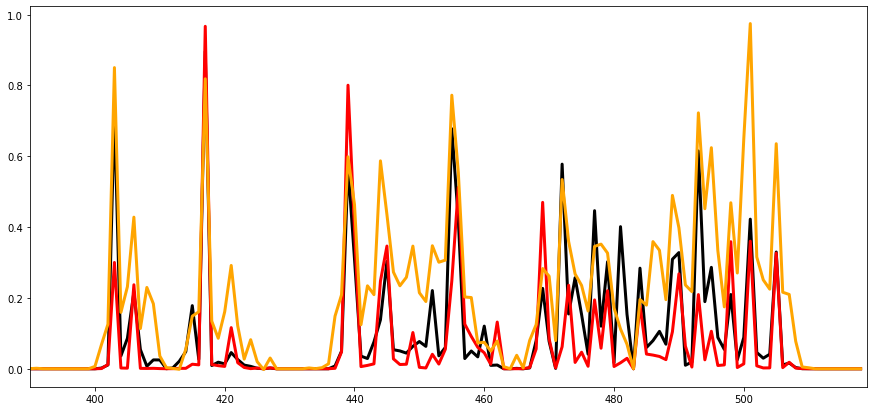

In [52]:
#get the final plot
LR_impo_res_cov2.mean().plot(figsize = (15,7), linewidth=3.0, color= 'black')
RF_impo_res_cov2.mean().plot(figsize = (15,7), linewidth=3.0, color='red')
mlp_impo_res_cov2.mean().plot(figsize = (15,7), xlim=(390, 519), linewidth=3.0, color = 'orange')
plt.savefig(output_dir +'per-residue_importance_all.ave_20.eps', format='eps')

In [60]:
#LR importance sum (the area below the importance profile)
LR_impo_res_cov2.mean().sum()

13.063142685563392

In [61]:
#RF importance sum (the area below the importance profile)
RF_impo_res_cov2.mean().sum()

8.88955906402989

In [62]:
#MLP importance sum (the area below the importance profile)
mlp_impo_res_cov2.mean().sum()

26.127582882786733

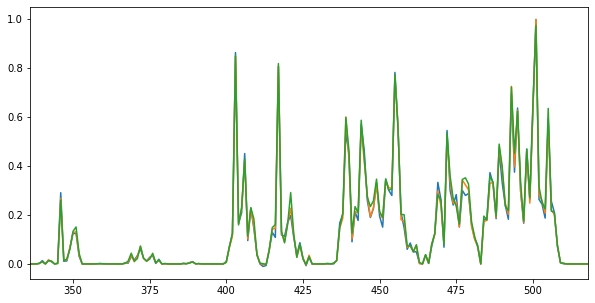

In [57]:
#check mlp convergence
mlp_impo_res_cov2.head(n = 5).mean().plot(figsize = (10,5))
mlp_impo_res_cov2.head(n = 10).mean().plot(figsize = (10,5))
mlp_impo_res_cov2.head(n = 20).mean().plot(figsize = (10,5))
plt.savefig(output_dir +'per-residue_importance_mlp.eps', format='eps')

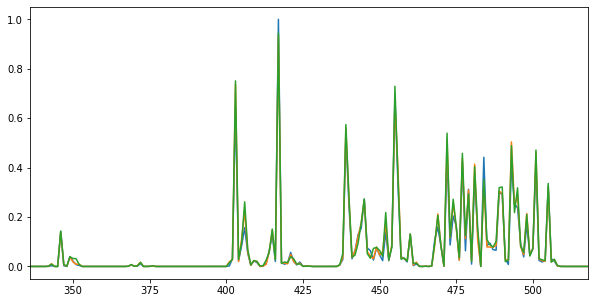

In [14]:
#check LR convergence
LR_impo_res_cov2.head(n = 5).mean().plot(figsize = (10,5))
LR_impo_res_cov2.head(n = 10).mean().plot(figsize = (10,5))
LR_impo_res_cov2.head(n = 20).mean().plot(figsize = (10,5))
plt.savefig(output_dir +'per-residue_importance_LR.eps', format='eps')